In [1]:
import os
import json
import torch
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn import svm
from transformers import AutoImageProcessor, AutoModel
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,ConfusionMatrixDisplay,classification_report

In [2]:
def create_list(dir,isImage=True,sort=False,fullPath=False):
  """
  Create list given directory.
  """
  lst = os.listdir(dir)

  if sort:
    lst = sort_list(lst,isImage)

  if fullPath:
    for i,img in enumerate(lst):
      path = os.path.join(dir,img)
      lst[i] = path

  return lst

## To manipulate data.
def sort_list(lst,isImage:bool=True):
  """
  Sort given list
  isImage used to check for images list or json list is given.
  """
  if not isImage:
    s = 5
  else:
    s = 4
  new_lst = []
  extensions = {}
  for i in range(0,len(lst)):
    id = Path(lst[i]).stem
    extensions[id] = lst[i][-s:]
    new_lst.append(int(id))

  new_lst = sorted(new_lst)

  for i in range(0,len(lst)):
    id = str(new_lst[i])
    new_lst[i]= id + extensions[id]
  return new_lst

def create_dict(keys,values):
  """
  Return created dictionary.
  """
  dictionary = {}
  for i,k in enumerate(keys):
    dictionary[k] = values[i]
  return dictionary

def create_img_label_dict(imgs_lst,labels_lst,column_num:int):
  """
  create dictionary with images as keys and excel labels as values.
  Image list must be sorted before call this function.
  For sorting call sort_image_list function before.
  """
  _dict = {}
  for i,img in enumerate(imgs_lst):
    _dict[img] = labels_lst.iloc[i,column_num]
  return _dict

def display_images_labels(imgs_lst,image_label_dictionary):
  """
  Return dataframe contains images and corresponding labels.
  """
  return pd.DataFrame({
      "Image" : [img for img in imgs_lst],
      "Label" : [image_label_dictionary[img] for img in imgs_lst]
  })

def get_values(keys,dictionary):
  """
  Given  keys, returns values from dictionary.
  """
  arr = []
  for key in keys:
    arr.append(dictionary[key])
  return arr

def get_data_from_json(json_file_path):
  """
  Returns data from given json path.
  """
  with open(json_file_path,'r') as file:
    data = json.load(file)
  return data

def create_cm(actual_labels,predicted,classes,title="Confusion Matrix"):
  """
  Create Confusion Matrix.
  """
  cm = confusion_matrix(actual_labels, predicted)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  cm_display.plot()
  plt.title(title)
  plt.show()

def calculate_metrics(labels,predictions):
  precision = precision_score(labels,predictions)
  recall = recall_score(labels,predictions)
  accuracy = accuracy_score(labels,predictions)
  return accuracy, precision, recall

In [3]:
images_dir = "/content/drive/MyDrive/Ara_proje_dataset/all_images"
excel_path = "/content/drive/MyDrive/Ara_proje_dataset/Total_Excel.xlsx"
classes = ("Hatasiz" , "Hatali")

labels = pd.read_excel(excel_path,header=None,keep_default_na=False)
images_ids = create_list(images_dir,sort=True)
img_lbl_dict = create_img_label_dict(images_ids,labels,column_num=1)
print("labels file length =", len(labels))
print("images list length =", len(images_ids))
print("dictionary  length =", len(img_lbl_dict))
display_images_labels(images_ids,img_lbl_dict)

labels file length = 1497
images list length = 1497
dictionary  length = 1497


,Image,Label
0,1.jpg,0
1,2.jpg,1
2,3.jpg,1
3,4.jpg,0
4,5.jpg,1
...,...,...
1492,3554.bmp,1
1493,3555.bmp,0
1494,3556.bmp,0
1495,3557.bmp,0


In [4]:
mandibula_data = get_data_from_json("/content/drive/MyDrive/Ara_proje_dataset/Models/DeiT_Embs_mandibular.json")
bg_data = get_data_from_json("/content/drive/MyDrive/Ara_proje_dataset/Models/DeiTImagesEmbs_butun_goruntu.json")

In [5]:
with open('/content/drive/MyDrive/Ara_proje_dataset/Models/DeiTbest_model_mandibular.pkl', 'rb') as f:
  mandibula_model = pickle.load(f)

with open('/content/drive/MyDrive/Ara_proje_dataset/Models/DeiTbest_model_butun_goruntu.pkl', 'rb') as f:
  bg_model = pickle.load(f)

In [6]:
def get_max_index(a,b):
  if a>b:
    return 0
  else:
    return 1

In [7]:
mandibula_embeddings = get_values(images_ids,mandibula_data)
bg_embeddings = get_values(images_ids,bg_data)
mand_emb_list = np.array(mandibula_embeddings)
bg_emb_list = np.array(bg_embeddings)
with torch.no_grad():
  mand_prob = mandibula_model.predict_proba(mand_emb_list)
  bg_prob = bg_model.predict_proba(bg_emb_list)

labels = get_values(images_ids,img_lbl_dict)

In [8]:
mand_pred = []
bg_pred = []
total_pred = []
w1 = 0.6
w2 = 0.8
for i in range(len(images_ids)):
  mand_pred.append(get_max_index(mand_prob[i][0],mand_prob[i][1]))
  bg_pred.append(get_max_index(bg_prob[i][0],bg_prob[i][1]))

  if mand_pred[i] == bg_pred[i]:
    total_pred.append(mand_pred[i])
  else:
    if mand_prob[i][mand_pred[i]] > bg_prob[i][bg_pred[i]]:
      total_pred.append(mand_pred[i])
    else:
      total_pred.append(bg_pred[i])

  print(f"image name {images_ids[i]}")
  print(f"mandibula: {mand_pred[i]}, {mand_prob[i]}")
  print(f"butun goruntu: {bg_pred[i]}, {bg_prob[i]}")
  print(f"Predicted: {total_pred[i]}, True: {labels[i]}")



Streaming output truncated to the last 5000 lines.
image name 345.jpg
mandibula: 0, [0.52485334 0.47514666]
butun goruntu: 0, [0.55203661 0.44796339]
Predicted: 0, True: 1
image name 348.jpg
mandibula: 0, [0.57312495 0.42687505]
butun goruntu: 0, [0.62015605 0.37984395]
Predicted: 0, True: 0
image name 350.jpg
mandibula: 0, [0.60295037 0.39704963]
butun goruntu: 0, [0.52695894 0.47304106]
Predicted: 0, True: 0
image name 351.jpg
mandibula: 0, [0.58424525 0.41575475]
butun goruntu: 0, [0.51563843 0.48436157]
Predicted: 0, True: 0
image name 353.jpg
mandibula: 1, [0.48727073 0.51272927]
butun goruntu: 1, [0.4506005 0.5493995]
Predicted: 1, True: 1
image name 355.jpg
mandibula: 0, [0.51048814 0.48951186]
butun goruntu: 1, [0.45232328 0.54767672]
Predicted: 1, True: 0
image name 357.jpg
mandibula: 0, [0.57997516 0.42002484]
butun goruntu: 0, [0.73485967 0.26514033]
Predicted: 0, True: 0
image name 358.jpg
mandibula: 1, [0.26664694 0.73335306]
butun goruntu: 1, [0.29742822 0.70257178]
Predi

Accuracy: 0.6907147628590514, Precision: 0.7114673242909988, Recall: 0.7158808933002482


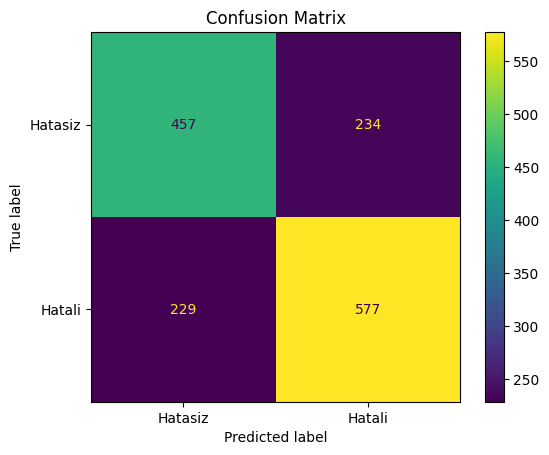

In [9]:
res = calculate_metrics(labels,total_pred)
print(f"Accuracy: {res[0]}, Precision: {res[1]}, Recall: {res[2]}")
create_cm(labels,total_pred,classes)